# Tutorial 1.a: Representing and Evaluating Uncertainty for Regression

This tutorial is the first in a series of tutorials on using torchuq for uncertainty quantification. If you haven't already, you can read the [Introduction] to understand the overall flow and objective of these tutorials. 

Before we start to work with any predictions we must first think about how to represent our prediction. For example, when predicting tomorrow's temperature, we might want to represent it as a single number (point prediction), such as 80F, or we might want to represent it as a cumulative density function (CDF). 

Each representation has its pros and cons. Depending on the different requirements during training/deployment, we might even want to convert between different representations. For example, we might initially start from an ensemble prediction (maybe because we trained multiple models), then convert it into a cumulative density function prediction or a point prediction (which are more interpretable and easier to work with). Conversion is one of the main features of torchuq, and we will come back to this topic in a later tutorial. 

This notebook aims to introduce some of the popular representations, and metrics to measure the quality of the prediction. Torchuq currently supports most popular representations and metrics. We will first discuss the regression setup (where the predicted quantity is a real number) and then discuss the classification setup (where the predicted quantity can take a finite number of values). 


We first list the types of predictions currently supported by torchuq for regression. You can skip this part and come back later as a reference. 

| Name          | Variable type/shape  |  Special requirement | torchuq sub-module for evaluation | 
| -----------   | --------------       |   --------- |  ------ |
| Point         | ``array [batch_size] with float32/64 dtype`` | | ``torchuq.metric.point`` |                       
| Distribution  | Python class that behaves like ``torch.distributions.Distribution`` || ``torchuq.metric.distribution`` |
| Interval      | ``array [batch_size, 2]``   | | ``torchuq.metric.interval `` | 
| Quantile      | ``array [batch_size, num_quantile, 2]`` or ``[batch_size, num_quantile]``  | The quantiles should be sorted, e.g. prediction\[i, j\] $\leq$ prediction\[i, j+1] | ``torchuq.metric.quantile``
| Particle      | ``array [batch_size, num_particle]``    | | ``torchuq.metric.particle``
| Ensemble      | ``dict: name -> prediction`` | name must start with prediction type and a string (with no special characters), such as 'point_1' | Not available 



## Running example 

As a running example we will predict the housing prices. For convenience, we have pretrained a set of predictions. In the following chapters we will see how to use torchuq to learn these predictions from data (hint: it only takes a few lines of code). But for now let's just load the pretrained predictions for visualization.

In [1]:
# We first must important the dependencies, and make sure that the torchuq package is in PYTHONPATH
# If you are running this notebook in the original directory as in the repo, then the following statement should work
import sys
sys.path.append('../..')   # Include the directory that contains the torchuq package
import torch  
from matplotlib import pyplot as plt

reader = torch.load('pretrained/boston_pretrained.tar')  # Load the pretrained predictions
labels = reader['labels']   # Load the true label (i.e. the ground truth housing prices)

## 1. Point Predictions

Point prediction is the simplest type of prediction, where we use a single number to represent the prediction. Point predictions are widespread because of their simplicity --- a single number is easy to communicate and interpret. However, point predictions do not represent the uncertainty in the prediction. 

A point prediction is represented by an torch array of shape `[batch_size]`. Note that following pytorch conventions, batching is mandatory in torchuq. For example, even when ``batch_size=1`` a point prediction must be represented as an array of shape `[1]` instead of a single number. Here we load the pretrained point prediction for the Boston housing dataset and print its shape. 

In [2]:
predictions_point = reader['predictions_point']
print(predictions_point.shape)

torch.Size([101])


There are many ways to visualize or measure the quality of a point prediction. Here we explain several common ones. For other visualizations and metrics please refer to [TBD] 

**Scatter plot** visualizes the relationship between the prediction and the label. On the x-axis we plot the predicted value, and on the y-axis we plot the true label. If the prediction is perfect, then all points should lie on the diagonal line (i.e. predicted value = true label). In torchuq this is accomlished by the `plot_scatter` function. 

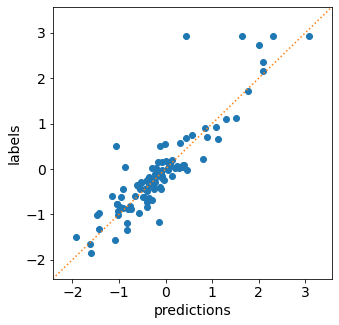

In [3]:
from torchuq.metric import point    # All point prediction metrics and visualizations are included in the torchuq.metric.point sub-package. 
point.plot_scatter(predictions_point, labels);

**Scoring Rules** The classic way to evaluate a point prediction is to compute scoring rules [1]. 

<details>
    <summary style="color:DodgerBlue"><b>[Click to expand]</b> A Detour into the Theory of Scoring Rules</summary>
   
    
    <p> Suppose we make a prediction $x$ and observe true label $y$, how do we quantitatively evaluate how good or bad the prediction is? A function that evaluates prediction quality is usually called a scoring function $s$, which is a map $s: x, y \mapsto s(x, y) \in \mathbb{R}$. An example scoring rule is the L2 score: $s_{\mathrm{L2}}(x, y) = (x - y)^2$. Intuitively, a high score indicates a poor prediction, and a low score indicates a good prediction. However, the exact meaning of good vs. poor prediction is ambiguous. The key issue is that a point prediction is never "perfect" if there is any uncertainty. If we predict $x$ while the true label is distributed according to the random variable $Y$, then we can never have $x = Y$ almost surely (unless there is no uncertainty so $Y$ is a deterministic random variable). For example, the median and the mean of $Y$ might be different, one practitioner might want to predict the median, and another practitioner might want to predict the mean. The two goals are inherently conflictory. </p>
    
    <p> To resolve the ambiguity we can specify the prediction target [1]. For example, we can aim to predict the mean, and design a scoring function that is small (i.e. indicates a good prediction) if the prediction $x$ is "close" to the mean $\mathbb{E}[Y]$. More generally, let $d_Y$ denote the probability law of the random variable $Y$, we specify some functional $F: d_Y \mapsto \mathbb{R}$ and aim to predict $F(d_Y)$. In the previous example, $F$ is the mean functional $F(d_Y) = \mathbb{E}(Y)$. We say that a scoring rule $s$ elicits $F$ if the score is small whenever $x \approx F(d_Y)$ and large whenever $x \not\approx F(d_Y)$. Formally this is defined by
    $$ \mathbb{E}[s(F(d_Y), Y)] \leq \mathbb{E}[s(x, Y)], \forall x $$
i.e. no prediction $x$ can achieve a smaller expected score than the desired prediction $F(d_Y)$. Many functionals have simple scoring rules that elicit them, below is a table
    
    <table>
        <tr> 
            <th> Functional </th> <th> </th>
            <th> Scoring rule </th> <th> </th>
        </tr> 
        <tr> 
            <th> Mean </th><th> $E[Y]$ </th>
            <th> L2 score </th><th>  $s(x, y) = (x - y)^2$ </th>
        <tr>
        <tr> 
            <th> $\alpha$-quantile </th><th> $\sup \lbrace y \mid \mathrm{Pr}[Y \leq y] \leq \alpha \rbrace$ </th> 
            <th> Pinball/hinge score </th><th> $s(x, y) = \left\lbrace \begin{array}{ll} \alpha (y - x) & y > x \\ (1 - \alpha) (x - y) & y \leq x \end{array} \right.$ </th>
        </tr> 
        <tr>
            <th> Unnamed </th> <th></th> 
            <th> Huber loss </th><th> $s(x, y) = \left\lbrace \begin{array}{ll} (x - y)^2/2 & |x - y| \leq \delta \\ |x - y| \delta - \delta^2/2 & |x - y| > \delta \end{array}\right.$ </th> 
        </tr> 
    </table> 
    </p>
    
    <p> For example, the typical L2 loss used in most regression problems elicit the mean functional. In other words, it rewards a prediction $x$ that equals the expectation $E[Y]$ (conditioned on all observed variables) but penalizes a prediction that equals the median or mode. Not all functionals have a scoring rule that elicit them. For example, the conditional value at risk (cVaR) [1] cannot be elicited by any score. In general, it is difficult to know if a functional can be elicited or not. There are some necessary *or* sufficient conditions (but no necessary *and* sufficient condition is known to the author's knowledge). </p>
</details>

<br> 
In torchuq common scoring rules are implemented with the ``compute_scores`` function. This function returns a dictionary with many common scores. To access individual scoring rules please refer to [TBD]

In [18]:
scores = point.compute_scores(predictions_point, labels)
print(scores)

tensor([1.5555e-03, 2.1511e-03, 3.1895e-03, 5.4511e-03, 7.2514e-03, 2.2974e-02,
        2.9645e-02, 3.5285e-02, 3.6171e-02, 3.6654e-02, 3.9089e-02, 4.4659e-02,
        4.6186e-02, 4.7605e-02, 5.0983e-02, 5.1842e-02, 5.3578e-02, 5.6377e-02,
        5.7058e-02, 5.7368e-02, 5.7978e-02, 6.2669e-02, 6.6483e-02, 7.1470e-02,
        7.2823e-02, 7.6672e-02, 7.9676e-02, 8.3146e-02, 8.3337e-02, 8.5405e-02,
        9.8600e-02, 1.0063e-01, 1.0868e-01, 1.1249e-01, 1.2631e-01, 1.2742e-01,
        1.3009e-01, 1.3616e-01, 1.3980e-01, 1.4046e-01, 1.4654e-01, 1.4853e-01,
        1.5596e-01, 1.6923e-01, 1.8139e-01, 1.8199e-01, 1.8322e-01, 1.8685e-01,
        1.8805e-01, 1.8873e-01, 1.9511e-01, 1.9953e-01, 2.2129e-01, 2.2407e-01,
        2.2818e-01, 2.3557e-01, 2.4356e-01, 2.4396e-01, 2.5374e-01, 2.5376e-01,
        2.5402e-01, 2.5715e-01, 2.6420e-01, 2.6845e-01, 2.7520e-01, 2.7613e-01,
        2.7816e-01, 2.8226e-01, 2.9392e-01, 2.9474e-01, 3.0993e-01, 3.1121e-01,
        3.1391e-01, 3.2977e-01, 3.3002e-

## 2. Distribution Predictions

A distribution prediction is a cumulative distribution function (CDF) over the label, i.e. it is a function $f: \mathbb{R} \to [0, 1]$ that is monotonic and upward continuous. Distribution prediction is very informative. For example, if we want to predict tomorrow's temperature, then a CDF prediction would specify the (predicted) probability of each possible temperature value. Ideally distribution predictions should predict the true probability: $ f(c) = \mathrm{Pr}[Y \leq c], \forall c$ though this is usually very difficult [2]. 

Torchuq inherits the torch interface for representing a distribution, i.e. a distribution prediction is represented by any class that behaves like (i.e. have the same methods and attributes) or inherits the [torch.distributions.distribution.Distribution](https://pytorch.org/docs/stable/distributions.html) class. Here we load the pretrained distribution prediction and verify that it has the correct type. 

In [5]:
predictions_distribution = reader['predictions_distribution']
print(predictions_distribution)
print(type(predictions_distribution))

Normal(loc: torch.Size([101]), scale: torch.Size([101]))
<class 'torch.distributions.normal.Normal'>


There are several metrics and visualizations available for distribution predictions: 

**Density Visualization** A way to intuitively visualize the predicted CDF is to visualize its [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (when it exists). In torchuq this is achieved by ``distribution.plot_density`` which takes as input a batch of CDF predictions, and plots the density for each prediction. The x-axis is the index of the prediction in the batch. 

**CDF Visualization** We can also visualize the CDF functions directly. This is particularly useful when density visualzation fails. For example, not all distributions have a density because the CDF could be dis-continnuous. In torchuq, visualizing the CDF is accomplished by the ``distribution.plot_cdf`` function. 

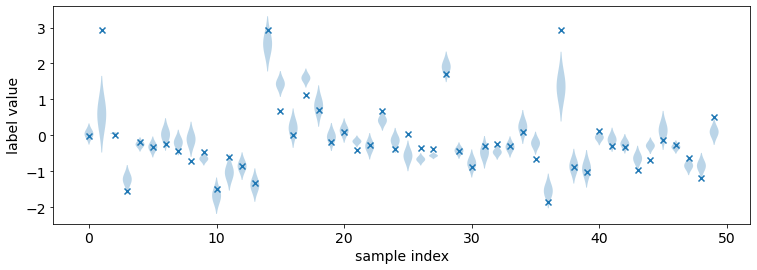

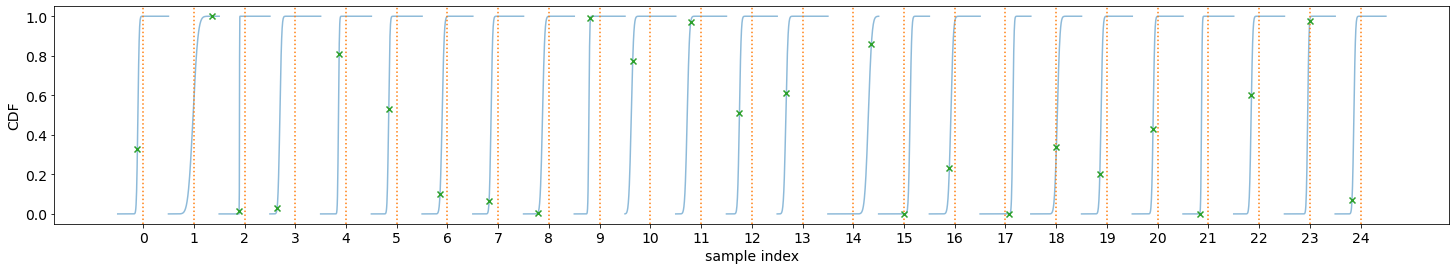

In [6]:
from torchuq.metric import distribution     # All distribution prediction metrics and visualizations are included in the torchuq.metric.point sub-package. 
# Pass in the optional argument "labels" to plot the true labels in the same diagram
# max_count is the maximum number of distributions to plot. Set a reasonable number (such as 50-100) to avoid cluttering the visualization. 
distribution.plot_density(predictions_distribution, labels, max_count=50)
distribution.plot_cdf_sequence(predictions_distribution, labels, max_count=25);

For more available visualizations please refer to [TBD] 

**Scoring Rules** To evaluate the quality of distribution predictions, we can use proper scoring rules. 
<details>
    <summary style="color:DodgerBlue"><b>[Click to expand]</b> Another Detour into the Theory of Scoring Rules</summary>
     
    <p> Let $f^*$ be the true CDF of $Y$, a proper scoring rule is any function that takes small (expected) value when the predicted CDF $f$ is close to the true CDF $f^*$, and large values otherwise. Formally a proper scoring function is a map $s: f, y \mapsto s(f, y) \in \mathbb{R}$ that satisfies 
$$ \mathbb{E}[s(f^*, Y)] \leq \mathbb{E}[s(f, Y)], \forall \text{ CDF } f$$
     In other words, no CDF can achieve a smaller score than the true CDF $f^*$ (in expectation). Scoring rules for distribution prediction is usually different from scoring rules for point predictions. 
    </p>

<p> There are many common proper scoring rules. Two commonly used scoring rules are 
    <ul>
<li> the negative log likelihood (NLL), defined by $s_{\mathrm{NLL}}(f, y) = -\log f'(y)$. Log likelihood is only defined when $f$ is differentiable (i.e. has a density function).  </li>
<li> the continuous ranked probability score (CRPS), defined by $s_{\mathrm{CRPS}}(f, y) = \int (f(x) - \mathbb{I}(x \geq y))^2 dx$. Unlike NLL, CRPS is defined even when $f$ is not differentiable. </li>
    </ul> 
   </p> 
</details>

In torchuq, the different scoring rules are implemented by functions such as ``distribution.compute_crps`` or ``distribution.compute_nll``. If the score is not defined then these functions will return nan. 

In [7]:
crps = distribution.compute_crps(predictions_distribution, labels).mean()
nll = distribution.compute_nll(predictions_distribution, labels).mean()
print("CRPS score is %.4f, nll score is %.4f " % (crps, nll))

CRPS score is 0.2276, nll score is 2.5124 


The following code demonstrates the fact that CRPS/NLL are proper scoring rules. If we try to predict a less accurate distribution (for example by intentionally shifting the predicted distribution), then the CRPS/NLL score will increase. 

In [8]:
# Try computing the crps for a worse predictive distribution 
import copy
bad_prediction = copy.deepcopy(predictions_distribution)
bad_prediction.loc += 0.5
crps = distribution.compute_crps(bad_prediction, labels).mean()
nll = distribution.compute_nll(bad_prediction, labels).mean()
print("CRPS score is %.4f, nll score is %.4f " % (crps, nll))

CRPS score is 0.4767, nll score is 18.2165 


**Reliability Diagram and Calibration** 
An important property for distribution prediction is (probabilistic) calibration [3, 4]. Intuitively, 90% of the labels should be below the predicted 90% quantile. Formally let $F$ be the random variable that denotes our prediction (Notation clarification: in the previous discussion, we use $f$ to denote a single distribution prediction; however it is only meaningful to talk about (probabilistic) calibration for a set/batch of predictions. Here we should think of $F$ a randomly selected prediction from the set/batch, and $Y$ is the label associated with the selected prediction)</sub>. Perfect probabilistic calibration is defined by
\begin{align}
\mathrm{Pr}(Y \leq F^{-1}(\alpha)) = \Pr[F(Y) \leq \alpha] = \alpha, \forall \alpha \in [0, 1] \label{eq:perfect_calibration}\tag{1}
\end{align}

Probabilitic calibration is only one of many calibration properties for distribution prediction. For additional calibration notions see [TBD]. 

To measure probabilistic calibration we can compute the deviation from perfect probabilistic calibration. There are two typical tools

1. **ECE metrics** measures the expected difference between the left hand side (LHS) and the right hand side (RHS) of Eq.(\ref{eq:perfect_calibration}) 
$$ \mathbb{E}[|\Pr[F(Y) \leq \alpha] - \alpha|] $$

2. **Reliability diagram** plots the map from $\alpha \mapsto \Pr[F(Y) \leq \alpha]$. If the predictor is perfectly calibrated, then the map should be the identity map. In torchuq use ``distribution.plot_reliability_diagram`` to plot the reliability diagram. Because of statistical fluctuations, a predictor that is perfectly probabilistically calibrated (on the entire population, or given infinite data) might be uncalibrated on a finite dataset. Torchuq will also automatically compute the confidence interval. If the recalibration diagram falls outside the confidence interval, then it very likely that the predictor is not calibrated on the entire population either.  



Debiased ECE is 0.069


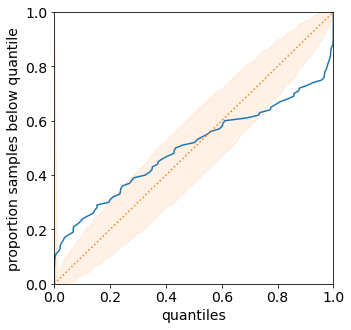

In [9]:
ece = distribution.compute_ece(predictions_distribution, labels, debiased=True) # ECE estimation is biased, if you enable the debiased option, then the expected ECE will be 0 for a perfectly calibrated predictor
print("Debiased ECE is %.3f" % ece)
distribution.plot_reliability_diagram(predictions_distribution, labels);

From the above ECE and reliability diagram, we can see that the predictions are not calibrated. We will discuss recalibration in a future tutorials. 

## 3. Quantile Predictions

There are situations where some uncertainty quantification is needed (hence a point prediction is insuffient), but we do not want to learn a full cumulative distribution function. A quantile prediction is a good intermediate representation that can quantify uncertainty but is not too complex. For example, our prediction might be "There is 10\% chance that tomorrow's temperature is less than 70F, and 90\% chance that it's less than 80F. Such simple predictions are often easier to visualize and communicate to the general public. 

In torchuq a quantile prediction is represented as an array of shape ``[batch_size, num_quantiles, 2]`` where ``prediction[:, :, 0]`` is the quantiles values (e.g. 70F, 80F), and ``prediction[:, :, 1]`` is the quantile probability (e.g. 10\%, 90\%). For example, to represent our example temperature prediction, we can use an array ``prediction`` of shape ``[1, 2, 2]``, and set ``prediction[0, 0, 0] = 70, prediction[0, 0, 1] = 0.1, prediction[0, 1, 0] = 80, prediction[0, 1, 1] = 0.9``. Again, we use mandatory batching, the batch dimension is necessary even if ``batch_size=1`` in this example.   

As a convenient shorthand, we can drop the quantile probabilities, and represent a quantile prediction as an array of shape ``[batch_size, num_quantiles]`` (only the quantile values are specified). The quantile probabilities are defined implicitly by the shape of the array (i.e. the value of ``num_quantiles``). It is implicitly defined as $\frac{1}{2 * \text{num_quantiles}}, \frac{3}{2 * \text{num_quantiles}}, \cdots, \frac{2 * \text{num_quantiles}-1}{2 * \text{num_quantiles}}$. For example, if ``num_quantiles=10`` then the quantile probabilities are implicitly defined as $0.05, 0.15, \cdots, 0.95$. 

Here we load the pretrained quantile predictions and verify that it has the correct shape. We use the implicit representation (with shape ``[batch_size, num_quantiles]``). 

In [10]:
predictions_quantile = reader['predictions_quantile']
print(predictions_quantile.shape)   # Here the quantiles are implicitly defined

torch.Size([101, 10])


There are several metrics and visualizations available for quantile predictions: 

**Quantile Visualization** We can directly plot the quantile predictions. Torchuq provides a function ``quantile.plot_quantiles`` where the different quantile probabilities are rendered in different color. For example, in the plot below the red colors are the upper quantiles (e.g. 95\%) quantile, and the blue colors are the lower quantiles (e.g. 5\% quantile). If the true label is also provided, it is plotted as green crosses. The x-axis is the index of the samples (e.g. ``predictions[0], predictions[1],`` $\cdots$).

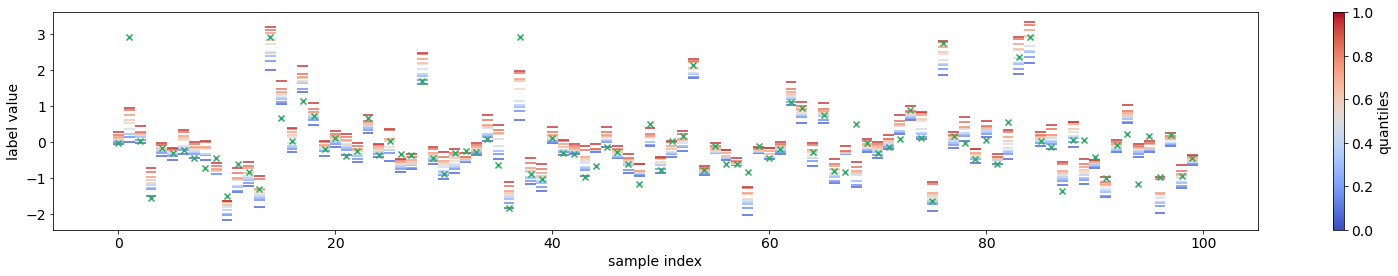

In [11]:
from torchuq.metric import quantile 
quantile.plot_quantiles(predictions_quantile, labels);

**Quantile calibration** Similar to a CDF prediction, a quantile prediction should also satisfy calibration, e.g. 90\% of the labels should be below the predicted 90\% quantile. The quantile calibration diagram is almost the same as the reliability diagram (for distribution predictions). In torchuq we can plot a quantile calibration diagram by ``quantile.plot_quantile_calibration``.

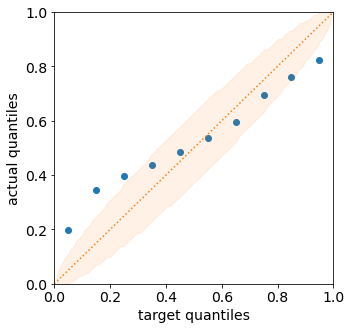

In [12]:
quantile.plot_quantile_calibration(predictions_quantile, labels)

In this case, the prediction is not calibrated. For example, the bottom-left dot shows that about 20\% of the labels are below the 5\% predicted quantile. We will discuss calibrating quantiles in a later tutorial. 

**Scoring rules** Similar to other types of predictions we discussed above, quantile predictions also have (proper) scoring rules. Intuitively a proper scoring rule should be small if the predicted quantile value equals the true quantile value, and large otherwise. For quantile predictions, a very important proper scoring rule is the **pinball loss** (also called the hinge loss). 

The following is an example of the pinball loss implemented in torchuq. 

In [13]:
pinball = quantile.compute_pinball_loss(predictions_quantile, labels).mean()
print("Pinball loss is %.3f" % pinball)

Pinball loss is 0.111


## 4. Interval Predictions

An interval prediction consists of a lower bound and an upper bound (denote by $L$, $U$). For example, an interval prediction can be "the weather is between 70 and 80 degrees. We say that an interval is valid if $Y \in [L, U]$ and say that a (batch) of interval predictions have $c$-coverage if $c$ proportion of the intervals are valid. 

In torchuq interval predictions are represented as an array of shape ``[batch_size, 2]`` where ``prediction[i, 0]`` denotes the lower bound of the $i$-th prediction and ``prediction[i, 1]`` denotes the upper bound of the $i$-th prediction. Here we load the example interval prediction and verify that it has the right shape. 

In [14]:
predictions_interval = reader['prediction_interval']
print(predictions_interval.shape)

torch.Size([101, 2])


**Direct Visualization** We provide a function to directly visualize an interval prediction. The different colors indicate whether the interval prediction is valid or not (i.e. if the label belongs to the predicted interval). 

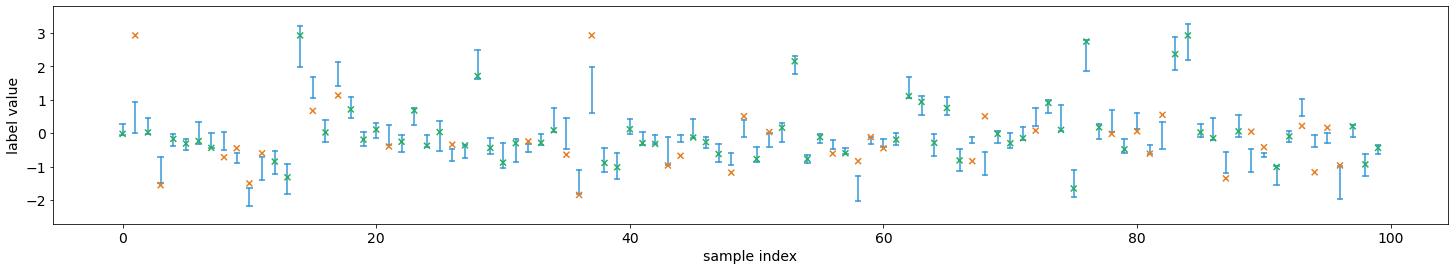

In [15]:
from torchuq.metric import interval 
interval.plot_intervals(predictions_interval, labels)

**Length and Coverage** Two important metrics for (a batch of) interval predictions are its length and coverage. You can use the function ``compute_length`` and ``compute_coverage`` to compute the average length and coverage. 


Length is 0.549, coverage is 0.624


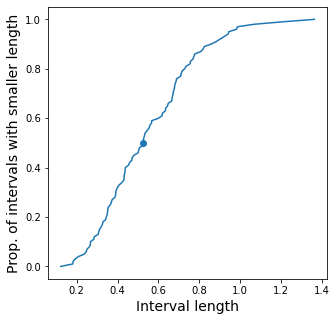

In [16]:
length = interval.compute_length(predictions_interval)
coverage = interval.compute_coverage(predictions_interval, labels)
print("Length is %.3f, coverage is %.3f" % (length, coverage))
interval.plot_length_cdf(predictions_interval);

# References

[1] Gneiting, Tilmann. "Making and evaluating point forecasts." Journal of the American Statistical Association 106, no. 494 (2011): 746-762.

[3] Gneiting, Tilmann, and Matthias Katzfuss. "Probabilistic forecasting." Annual Review of Statistics and Its Application 1 (2014): 125-151. 

[4] Kuleshov, Volodymyr, Nathan Fenner, and Stefano Ermon. "Accurate uncertainties for deep learning using calibrated regression." In International Conference on Machine Learning, pp. 2796-2804. PMLR, 2018.